# Data


In [1]:
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset

In [2]:
num_images_per_label = 1000  
dataset_name = 'FashionMNIST' # 'MNIST' or 'CIFAR10'

In [3]:
if dataset_name == 'MNIST':
    dataset = MNIST(root='./../data', train=True, download=True, transform=ToTensor())
elif dataset_name == 'CIFAR10':
    dataset = CIFAR10(root='./../data', train=True, download=True, transform=ToTensor())
elif dataset_name == 'FashionMNIST':
    dataset = FashionMNIST(root='./../data', train=True, download=True, transform=ToTensor())
else:
    raise ValueError("Unsupported dataset. Please choose 'MNIST' or 'CIFAR10'.")

# Custom dataset to filter 1000 samples per label
class FilteredDataset(TensorDataset):
    def __init__(self, dataset, num_images_per_label):
        self.dataset = dataset
        self.num_images_per_label = num_images_per_label
        self.filtered_data = []
        self._filter_dataset()

    def _filter_dataset(self):
        label_counts = {i: 0 for i in range(len(self.dataset.classes))}
        for image, label in self.dataset:
            if label_counts[label] < self.num_images_per_label:
                self.filtered_data.append((image, label))
                label_counts[label] += 1
            if all(count >= self.num_images_per_label for count in label_counts.values()):
                break

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, index):
        return self.filtered_data[index]

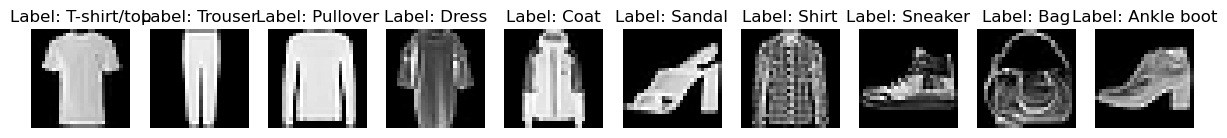

In [4]:
# Create the filtered dataset
filtered_dataset = FilteredDataset(dataset, num_images_per_label)
dataloader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)

# Visualize the dataset
import matplotlib.pyplot as plt

def visualize_dataset(dataloader, label_show=True):
    # Visualize one image from each class
    classes = dataloader.dataset.dataset.classes
    images, labels = [], []
    for i in range(len(classes)):
        for image, label in dataloader:
            if label[0] == i:
                images.append(image[0])
                labels.append(label[0])
                break  # Only one image per class

    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        img_np = img.permute(1, 2, 0).numpy()
        if img_np.shape[2] == 1:
            img_np = img_np.squeeze(-1)  # For grayscale
        ax.imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        if label_show:
            ax.set_title(f'Label: {classes[label]}')
        ax.axis('off')
    plt.show()
        
    
visualize_dataset(dataloader)

In [5]:
# image shape 
print(f"Image shape: {filtered_dataset[0][0].shape}")
print(f"Number of samples: {len(filtered_dataset)}")

Image shape: torch.Size([1, 28, 28])
Number of samples: 10000


# Conditional Flow Matching

In [6]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models import UNetModel
from models import OptimalTransport
import torch 

device = 'mps' if torch.mps.is_available() else 'cpu'

model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

sampler = OptimalTransport(
    sigma_min=0.0001,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Device: {device}")
print(f"Data shape: {filtered_dataset[0][0].shape}")  
print(f"Number of classes: {len(filtered_dataset.dataset.classes)}")
print(f"Number of samples per class: {num_images_per_label}")
print(f"Number of total samples: {len(filtered_dataset)}")

Device: mps
Data shape: torch.Size([1, 28, 28])
Number of classes: 10
Number of samples per class: 1000
Number of total samples: 10000


In [7]:
# Load pre-trained model if available
path_pretrained = '../checkpoint/2025-06-22_10-50-50'
model.load_state_dict(torch.load(os.path.join(path_pretrained, 'unet_model.pth'), map_location=device))
print(f"Loaded pre-trained model from {path_pretrained}")
optimizer.load_state_dict(torch.load(os.path.join(path_pretrained, 'optimizer.pth'), map_location=device))
print(f"Loaded pre-trained optimizer from {path_pretrained}")

Loaded pre-trained model from ../checkpoint/2025-06-22_10-50-50
Loaded pre-trained optimizer from ../checkpoint/2025-06-22_10-50-50


## Train

In [43]:
from tqdm import tqdm

epochs = 10
for epoch in range(epochs):  # Single epoch for demonstration
    epoch_loss = 0.0
    for i, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)

        # Compute loss
        loss = sampler.loss(model, X, class_condition=y)

        # Zero gradients
        optimizer.zero_grad()

        # Standard backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader)}")
    epoch_loss = 0.0  # Reset loss for the next epoch

100%|██████████| 313/313 [00:55<00:00,  5.65it/s]


Epoch 1/10, Loss: 0.1994518782860174


100%|██████████| 313/313 [00:49<00:00,  6.28it/s]


Epoch 2/10, Loss: 0.1406091439266936


100%|██████████| 313/313 [00:49<00:00,  6.34it/s]


Epoch 3/10, Loss: 0.13204836647826643


100%|██████████| 313/313 [00:49<00:00,  6.27it/s]


Epoch 4/10, Loss: 0.12757267764867686


100%|██████████| 313/313 [00:49<00:00,  6.32it/s]


Epoch 5/10, Loss: 0.12467555235178707


100%|██████████| 313/313 [00:49<00:00,  6.34it/s]


Epoch 6/10, Loss: 0.12292870315023885


100%|██████████| 313/313 [00:51<00:00,  6.12it/s]


Epoch 7/10, Loss: 0.12119478334824497


100%|██████████| 313/313 [00:51<00:00,  6.06it/s]


Epoch 8/10, Loss: 0.1209833427978019


100%|██████████| 313/313 [00:49<00:00,  6.37it/s]


Epoch 9/10, Loss: 0.11640062354528866


100%|██████████| 313/313 [00:49<00:00,  6.36it/s]

Epoch 10/10, Loss: 0.11708621821178795


## Save Model

In [ ]:
# Save the model
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
if not os.path.exists('../checkpoint'):
    os.makedirs('../checkpoint')
if not os.path.exists(f'../checkpoint/{date}'):
    os.makedirs(f'../checkpoint/{date}')
print(f"Saving model to ../checkpoint/{date}/unet_model.pth")
torch.save(model.state_dict(), f'../checkpoint/{date}/unet_model.pth')
print(f"Saving optimizer state to ../checkpoint/{date}/optimizer.pth")
torch.save(optimizer.state_dict(), f'../checkpoint/{date}/optimizer.pth')

Saving model to ../checkpoint/2025-06-22_10-50-50/unet_model.pth
Saving optimizer state to ../checkpoint/2025-06-22_10-50-50/optimizer.pth


## Sampling and Visualize

In [65]:
import torchdiffeq

CONDITION = torch.tensor([x for x in range(10)], device=device)  # Condition for all class
N_SAMPLES = 10  # Number of samples to generate
STEPS = torch.linspace(0, 1, 20, device=device)

with torch.no_grad():
    # with torch.autocast(device_type="cuda", dtype=torch.float16):
        traj = torchdiffeq.odeint(
            lambda t, x: model(t, x, CONDITION),
            torch.randn(N_SAMPLES, 1, 28, 28, device=device),
            STEPS,
            atol=1e-4,
            rtol=1e-4,
            method="euler",
        )
        
traj = traj[-1]  # Get the last time step

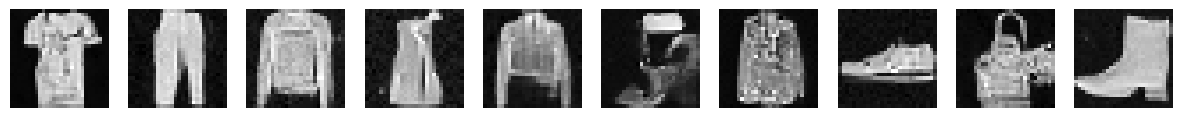

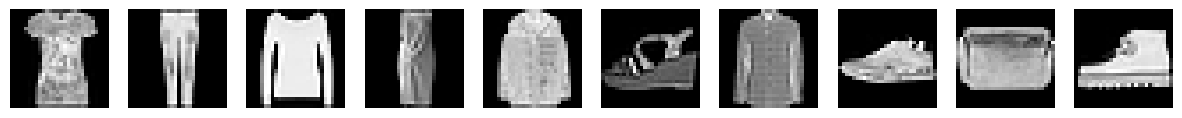

In [66]:
# Visualize the generated samples
fig, axes = plt.subplots(1, N_SAMPLES, figsize=(15, 5))
for ax, img in zip(axes, traj):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    if img_np.shape[2] == 1:
        img_np = img_np.squeeze(-1)  # For grayscale
    ax.imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
    ax.axis('off')
plt.show()

# Visualize ground truth samples
visualize_dataset(dataloader, label_show=False)

## Metrics

## FID

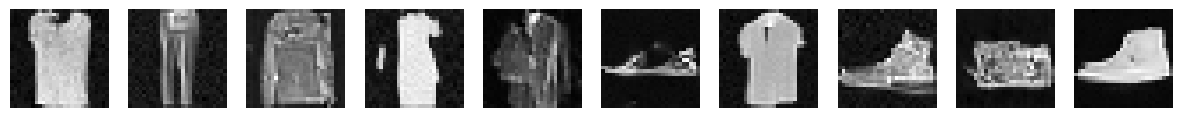

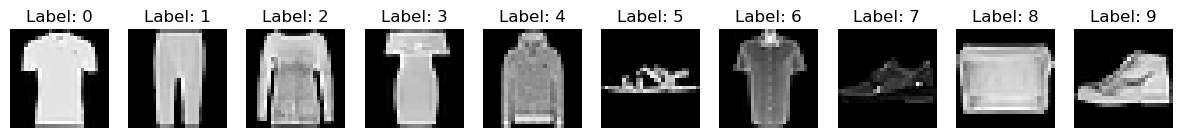

In [16]:
import torchdiffeq

def save_generated(folder_path, model, condition: torch.Tensor, steps: torch.Tensor, n_samples: int, device: str):
    with torch.no_grad():
        traj = torchdiffeq.odeint(
            lambda t, x: model(t, x, condition),
            torch.randn(n_samples, 1, 28, 28, device=device),
            steps,
            atol=1e-4,
            rtol=1e-4,
            method="euler",
        )
    traj = traj[-1]  # Get the last time step

    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)

    # Save the generated samples
    for idx, img in enumerate(traj):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        if img_np.shape[-1] == 1:
            img_np = img_np.squeeze(-1)  # For grayscale
        # Save each image, use the corresponding condition label if available
        label = condition[idx].item() if condition.numel() > 1 else condition.item()
        label_folder = os.path.join(folder_path, f'{label}')
        if not os.path.exists(label_folder):
            os.makedirs(label_folder, exist_ok=True)
        plt.imsave(os.path.join(label_folder, f'sample_{label}.png'), img_np)
        
    # Visualize the generated samples
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    for ax, img in zip(axes, traj):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        if img_np.shape[-1] == 1:
            img_np = img_np.squeeze(-1)  # For grayscale
        ax.imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        ax.axis('off')
    plt.show()
    
def save_ground_truth(folder_path, dataloader):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)

    # Save one image per class (0-9)
    saved_labels = set()
    images = []
    labels = []
    for images_batch, labels_batch in dataloader:
        for img, label in zip(images_batch, labels_batch):
            label_int = int(label.item())
            if label_int not in saved_labels:
                label_folder = os.path.join(folder_path, f'{label_int}')
                if not os.path.exists(label_folder):
                    os.makedirs(label_folder, exist_ok=True)
                img_np = img.permute(1, 2, 0).cpu().numpy()
                if img_np.shape[-1] == 1:
                    img_np = img_np.squeeze(-1)  # For grayscale
                plt.imsave(os.path.join(label_folder, f'ground_truth_{label_int}.png'), img_np)
                images.append(img)
                labels.append(label_int)
                saved_labels.add(label_int)
            if len(saved_labels) == 10:
                break
        if len(saved_labels) == 10:
            break

    # Sort images and labels by class label before visualization
    sorted_pairs = sorted(zip(labels, images), key=lambda x: x[0])
    labels, images = zip(*sorted_pairs)

    # Visualize the ground truth samples
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        if img_np.shape[-1] == 1:
            img_np = img_np.squeeze(-1)  # For grayscale
        ax.imshow(img_np, cmap='gray' if img_np.ndim == 2 else None)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()
    
CONDITION = torch.tensor([x for x in range(10)], device=device)  # Condition for all class
N_SAMPLES = 10  # Number of samples to generate
STEPS = torch.linspace(0, 1, 20, device=device)

save_generated(f'../image/generated_samples', model, CONDITION, STEPS, N_SAMPLES, device)
save_ground_truth(f'../image/ground_truth_samples', dataloader)

Computing FID for label 0...
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.28s/it]
Label 0: FID = 198.46867317219503


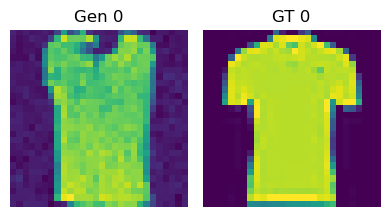

Computing FID for label 1...
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.05s/it]
Label 1: FID = 247.55687570185057


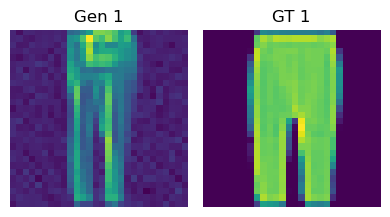

Computing FID for label 2...
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]
Label 2: FID = 238.7468399786466


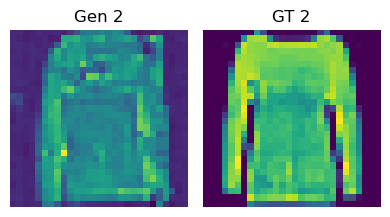

Computing FID for label 3...
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.78s/it]
Label 3: FID = 251.52141978818804


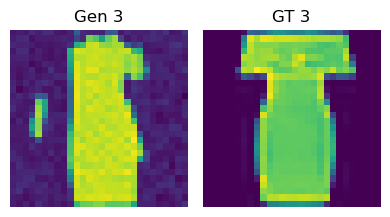

Computing FID for label 4...
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.69s/it]
Label 4: FID = 258.0574804513939


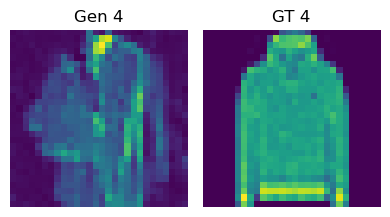

Computing FID for label 5...
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]
Label 5: FID = 99.60328850960192


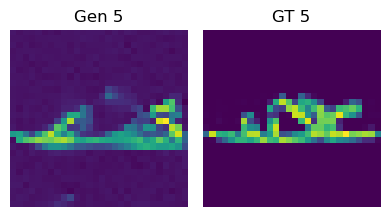

Computing FID for label 6...
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.91s/it]
Label 6: FID = 231.90921112104974


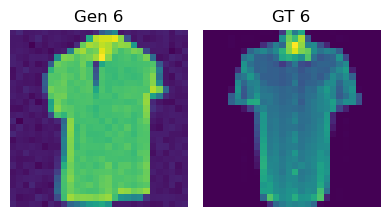

Computing FID for label 7...
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.34s/it]
Label 7: FID = 234.2446758159107


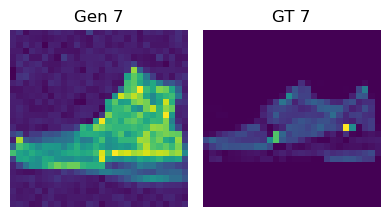

Computing FID for label 8...
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.02s/it]
Label 8: FID = 256.5688103418216


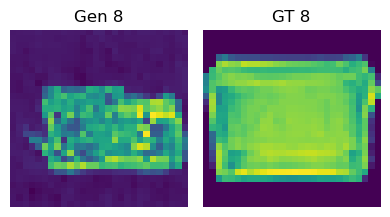

Computing FID for label 9...
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.79s/it]
Label 9: FID = 158.82435060379902


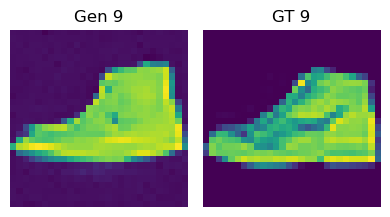

FID scores per label: {0: 198.46867317219503, 1: 247.55687570185057, 2: 238.7468399786466, 3: 251.52141978818804, 4: 258.0574804513939, 5: 99.60328850960192, 6: 231.90921112104974, 7: 234.2446758159107, 8: 256.5688103418216, 9: 158.82435060379902}


In [8]:
from PIL import Image
import glob

import matplotlib.pyplot as plt

fid_scores = {}

for label in range(10):
    # Compute FID for current label
    print(f"Computing FID for label {label}...")
    !python -m pytorch_fid ../image/generated_samples/{label} ../image/ground_truth_samples/{label} --batch-size 1 --device mps > ../image/fid_tmp.txt
    with open("../image/fid_tmp.txt") as f:
        for line in f:
            if "FID:" in line:
                fid_scores[label] = float(line.strip().split()[-1])
                print(f"Label {label}: FID = {fid_scores[label]}")

    # Visualize 1 image from generated and 1 from ground truth
    gen_imgs = sorted(glob.glob(f'../image/generated_samples/{label}/*.png'))
    gt_imgs = sorted(glob.glob(f'../image/ground_truth_samples/{label}/*.png'))
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))
    # Show generated image
    if len(gen_imgs) > 0:
        axes[0].imshow(Image.open(gen_imgs[0]), cmap='gray')
        axes[0].set_title(f'Gen {label}')
    axes[0].axis('off')
    # Show ground truth image
    if len(gt_imgs) > 0:
        axes[1].imshow(Image.open(gt_imgs[0]), cmap='gray')
        axes[1].set_title(f'GT {label}')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

print("FID scores per label:", fid_scores)

# Remove temporary file
import os
if os.path.exists("../image/fid_tmp.txt"):
    os.remove("../image/fid_tmp.txt")